# 1. Introduction

In this post I am going to talk about how to apply the natural lanugage processing techniques to the recommender system. In many real cases, for instance, if we have finished a course in Coursera, we want to learn some related courses to get a deeper insight into one research field. Hence, it would be better if our online system could automatically recommend some relevant courses for a learner.

If we talk more about this coursera case, some people might say we could use labels to tag all the courses previously and if one learner finished one course, based on the label the system would post some relevant courses. However, manually labelling huge number of courses is very time consuming. Moreover, some algorithms such as collaborative filtering and content-based filtering could also help this problem. But these approaches would not work if we had a new course on Coursera and we did not have much feedback(data) from users about this course. **A better approach** to this problem is that we utilize the title and the description of each course and use NLP techniques to work out for instance the similarity of two courses. Based on this similarity, our system could automatically recommende coursers to our users. The following sections will show the main techniques we use.

So let's get started!

# 2. Construct the NLP Models

In this section we show how to create a recommendation system for our Coursera users. Let's first import modules for this task.

## 2.1 Load the dataset

First we import all the modules we need in this case study.

In [96]:
import nltk
import re
import string
import time
import math
import numpy as np

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.lancaster import LancasterStemmer

from gensim import corpora, models, similarities, matutils

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.metrics.pairwise import cosine_similarity

from matplotlib import pyplot as plt

Then we load the data. The data can be found in here: [Coursera corpus](https://github.com/bright1993ff66/Text-Data-Analysis/blob/master/Recommender%20System/coursera_corpus)

In [2]:
file = open('F:/Data Analysis/github/Text-Data-Analysis/Recommender System/coursera_corpus', 'r', encoding = 'UTF-8')
courses = [line.strip() for line in file]
courses[:2]

['Writing II: Rhetorical Composing\tRhetorical Composing engages you in a series of interactive reading, research, and composing activities along with assignments designed to help you become more effective consumers and producers of alphabetic, visual and multimodal texts.  Join us to become more effective writers... and better citizens.\tRhetorical Composing is a course where writers exchange words, ideas,     talents, and support. You will be introduced to a variety of rhetorical     concepts—that is, ideas and techniques to inform and persuade audiences—that     will help you become a more effective consumer and producer of written,     visual, and multimodal texts. The class includes short videos, demonstrations,     and activities. We envision Rhetorical Composing as a learning community that includes both those enrolled in this course and the instructors. We bring our expertise in writing, rhetoric and course design, and we have designed the assignments and course infrastructure 

From the output, we see that the names of the courses are seperated by tab. Hence we use the following code to extract the courses' names.

In [3]:
courses_name = [course.split('\t')[0] for course in courses]
courses_name[:10]

['Writing II: Rhetorical Composing',
 'Genetics and Society: A Course for Educators',
 'General Game Playing',
 'Genes and the Human Condition (From Behavior to Biotechnology)',
 'A Brief History of Humankind',
 'New Models of Business in Society',
 'Analyse Numérique pour Ingénieurs',
 'Evolution: A Course for Educators',
 'Coding the Matrix: Linear Algebra through Computer Science Applications',
 'The Dynamic Earth: A Course for Educators']

## 2.2 Preprocess the data

Generally, we need to do the following text pre-processing:

1. lowercase the words
2. eliminate punctuations
3. eliminate the stopwords
3. stemming

In [4]:
text_lower = [[word for word in document.lower().split()] for document in courses]
print(text_lower[0], end = '\t')

['writing', 'ii:', 'rhetorical', 'composing', 'rhetorical', 'composing', 'engages', 'you', 'in', 'a', 'series', 'of', 'interactive', 'reading,', 'research,', 'and', 'composing', 'activities', 'along', 'with', 'assignments', 'designed', 'to', 'help', 'you', 'become', 'more', 'effective', 'consumers', 'and', 'producers', 'of', 'alphabetic,', 'visual', 'and', 'multimodal', 'texts.', 'join', 'us', 'to', 'become', 'more', 'effective', 'writers...', 'and', 'better', 'citizens.', 'rhetorical', 'composing', 'is', 'a', 'course', 'where', 'writers', 'exchange', 'words,', 'ideas,', 'talents,', 'and', 'support.', 'you', 'will', 'be', 'introduced', 'to', 'a', 'variety', 'of', 'rhetorical', 'concepts—that', 'is,', 'ideas', 'and', 'techniques', 'to', 'inform', 'and', 'persuade', 'audiences—that', 'will', 'help', 'you', 'become', 'a', 'more', 'effective', 'consumer', 'and', 'producer', 'of', 'written,', 'visual,', 'and', 'multimodal', 'texts.', 'the', 'class', 'includes', 'short', 'videos,', 'demonstr

From the text above, we see some output such as 'texts.' does not split the word and the punctuation. Hence, it would be better if we could use the **word_tokenize** function in nltk and get a more meaningful result.

In [5]:
text_lower = [[word.lower() for word in word_tokenize(document)] for document in courses]
print(text_lower[0], end = '\t')

['writing', 'ii', ':', 'rhetorical', 'composing', 'rhetorical', 'composing', 'engages', 'you', 'in', 'a', 'series', 'of', 'interactive', 'reading', ',', 'research', ',', 'and', 'composing', 'activities', 'along', 'with', 'assignments', 'designed', 'to', 'help', 'you', 'become', 'more', 'effective', 'consumers', 'and', 'producers', 'of', 'alphabetic', ',', 'visual', 'and', 'multimodal', 'texts', '.', 'join', 'us', 'to', 'become', 'more', 'effective', 'writers', '...', 'and', 'better', 'citizens', '.', 'rhetorical', 'composing', 'is', 'a', 'course', 'where', 'writers', 'exchange', 'words', ',', 'ideas', ',', 'talents', ',', 'and', 'support', '.', 'you', 'will', 'be', 'introduced', 'to', 'a', 'variety', 'of', 'rhetorical', 'concepts—that', 'is', ',', 'ideas', 'and', 'techniques', 'to', 'inform', 'and', 'persuade', 'audiences—that', 'will', 'help', 'you', 'become', 'a', 'more', 'effective', 'consumer', 'and', 'producer', 'of', 'written', ',', 'visual', ',', 'and', 'multimodal', 'texts', '.

The words and the punctuations have been splitted. Then we need to do is eliminate the punctuatiaons.

In [6]:
x = re.compile('[%s]' % re.escape(string.punctuation))
text_lower_no_punctuation = []

for text in text_lower:
    new_text = []
    for token in text:
        new_token = x.sub(u'',token) 
        if not new_token == u'':
            new_text.append(new_token)
    text_lower_no_punctuation.append(new_text)
    
print(text_lower_no_punctuation[0], end = "\t")

['writing', 'ii', 'rhetorical', 'composing', 'rhetorical', 'composing', 'engages', 'you', 'in', 'a', 'series', 'of', 'interactive', 'reading', 'research', 'and', 'composing', 'activities', 'along', 'with', 'assignments', 'designed', 'to', 'help', 'you', 'become', 'more', 'effective', 'consumers', 'and', 'producers', 'of', 'alphabetic', 'visual', 'and', 'multimodal', 'texts', 'join', 'us', 'to', 'become', 'more', 'effective', 'writers', 'and', 'better', 'citizens', 'rhetorical', 'composing', 'is', 'a', 'course', 'where', 'writers', 'exchange', 'words', 'ideas', 'talents', 'and', 'support', 'you', 'will', 'be', 'introduced', 'to', 'a', 'variety', 'of', 'rhetorical', 'concepts—that', 'is', 'ideas', 'and', 'techniques', 'to', 'inform', 'and', 'persuade', 'audiences—that', 'will', 'help', 'you', 'become', 'a', 'more', 'effective', 'consumer', 'and', 'producer', 'of', 'written', 'visual', 'and', 'multimodal', 'texts', 'the', 'class', 'includes', 'short', 'videos', 'demonstrations', 'and', 'a

The punctuations have been removed. After that, we need to remove the unmeaningful stopwords. Fortunately, nltk provides us with a list of stopwords which are helpful in this task.

In [7]:
english_stopwords = stopwords.words('english')

In [143]:
text_filtered = [[word for word in document if word not in english_stopwords ] for document in text_lower_no_punctuation]
print(text_filtered[0:2], end = "\t")

[['writing', 'ii', 'rhetorical', 'composing', 'rhetorical', 'composing', 'engages', 'series', 'interactive', 'reading', 'research', 'composing', 'activities', 'along', 'assignments', 'designed', 'help', 'become', 'effective', 'consumers', 'producers', 'alphabetic', 'visual', 'multimodal', 'texts', 'join', 'us', 'become', 'effective', 'writers', 'better', 'citizens', 'rhetorical', 'composing', 'course', 'writers', 'exchange', 'words', 'ideas', 'talents', 'support', 'introduced', 'variety', 'rhetorical', 'concepts—that', 'ideas', 'techniques', 'inform', 'persuade', 'audiences—that', 'help', 'become', 'effective', 'consumer', 'producer', 'written', 'visual', 'multimodal', 'texts', 'class', 'includes', 'short', 'videos', 'demonstrations', 'activities', 'envision', 'rhetorical', 'composing', 'learning', 'community', 'includes', 'enrolled', 'course', 'instructors', 'bring', 'expertise', 'writing', 'rhetoric', 'course', 'design', 'designed', 'assignments', 'course', 'infrastructure', 'help', 

At last, we do the stemming for this text. Stemming in NLP means that we treat each word's different variants as the same word. For instance for playing, played, play, we see them as a same word:play. nltk has many useful stemmers. The most well-know ones are Lancaster Stemmer and Porter Stemmer. Here we use Lancaster Stemmer to cope with this Coursera corpus.

In [9]:
st = LancasterStemmer()
text_stemmed = [[st.stem(word) for word in docment] for docment in text_filtered]
print(text_stemmed[0], end = "\t")

['writ', 'ii', 'rhet', 'compos', 'rhet', 'compos', 'eng', 'sery', 'interact', 'read', 'research', 'compos', 'act', 'along', 'assign', 'design', 'help', 'becom', 'effect', 'consum', 'produc', 'alphabet', 'vis', 'multimod', 'text', 'join', 'us', 'becom', 'effect', 'writ', 'bet', 'cit', 'rhet', 'compos', 'cours', 'writ', 'exchang', 'word', 'idea', 'tal', 'support', 'introduc', 'vary', 'rhet', 'concepts—that', 'idea', 'techn', 'inform', 'persuad', 'audiences—that', 'help', 'becom', 'effect', 'consum', 'produc', 'writ', 'vis', 'multimod', 'text', 'class', 'includ', 'short', 'video', 'demonst', 'act', 'envid', 'rhet', 'compos', 'learn', 'commun', 'includ', 'enrol', 'cours', 'instruct', 'bring', 'expert', 'writ', 'rhet', 'cours', 'design', 'design', 'assign', 'cours', 'infrastruct', 'help', 'shar', 'expery', 'writ', 'stud', 'profess', 'us', 'collab', 'facilit', 'wex', 'writ', 'exchang', 'plac', 'exchang', 'work', 'feedback']	

## 2.3 Train the data

We have finished the text data preprocessing. Next, we will fead the data to our NLP models. First, let's construct a bag-of-words model.

### 2.3.1 LSI Model

In [10]:
dictionary = corpora.Dictionary(text_stemmed)

Then we construct the bag-of-words model.

In [11]:
print(dictionary)

Dictionary(5886 unique tokens: ['netflix', 'selen', '16th', 'pur', 'multipl']...)


From the dictionary, we get the id of each unique word. Then we could calculate how many times a word appears in this Coursera corpus.

In [12]:
'''
doc2bow converts `document` (a list of words) into the bag-of-words format
'''
corpus = [dictionary.doc2bow(text) for text in text_stemmed] 

In [13]:
print(corpus[0], end = ' ')

[(0, 1), (1, 3), (2, 1), (3, 2), (4, 1), (5, 1), (6, 2), (7, 3), (8, 1), (9, 6), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 2), (17, 7), (18, 1), (19, 3), (20, 1), (21, 1), (22, 2), (23, 4), (24, 1), (25, 1), (26, 1), (27, 2), (28, 2), (29, 1), (30, 2), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 2), (40, 5), (41, 1), (42, 2), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 2), (55, 1), (56, 1), (57, 1), (58, 3), (59, 1), (60, 1), (61, 3)] 

Then we could construct the TF-IDF model. The value of TF-IDF could be calculated as follows:

\begin{equation}
TF-IDF(x) = TF(X) \times IDF(X)
\end{equation}

where $TF(x)$ means the word frequency of a word $x$. $IDF(x)$ represents the importance of a word $X$. We usually use the following formular to calcualte the $IDF(X)$:

\begin{equation}
IDF(X) = log\frac{N+1}{N(x)+1} + 1
\end{equation}

where $N$ means the number of documents and $N(x)$ means the number of documents with word $x$. Sometimes, we could not find the term $x$ in all of our documents. Hence, it would be better if we could just add 1 to both of numerator and the denominator.

Hence, we could train a TF-IDF model based on our bag-of-words format.

In [14]:
tfidf = models.TfidfModel(corpus)

Then we could calculate the TF-IDF value for each word in this corpus.

In [15]:
corpus_tfidf = tfidf[corpus]

In [16]:
docs = [doc for doc in corpus_tfidf]
print(docs[0], end =' ')

[(0, 0.06942854357795676), (1, 0.1092155063059081), (2, 0.03640516876863603), (3, 0.12037571819073922), (4, 0.06942854357795676), (5, 0.07758199632369395), (6, 0.0610785615827926), (7, 0.0880889612390743), (8, 0.046249439563031396), (9, 0.5838322958557992), (10, 0.02451348611154219), (11, 0.05549012404561855), (12, 0.11939725492070859), (13, 0.0354549657646678), (14, 0.04848606348417998), (15, 0.11939725492070859), (16, 0.07911819315429061), (17, 0.3096581070133701), (18, 0.04848606348417998), (19, 0.08740729674093296), (20, 0.030783027881683914), (21, 0.05100295519983211), (22, 0.04241906866790852), (23, 0.009926203812253558), (24, 0.049705157259017516), (25, 0.08336696311029498), (26, 0.07758199632369395), (27, 0.022058022218786385), (28, 0.1093384781995657), (29, 0.03608341968474428), (30, 0.13265748941711367), (31, 0.11939725492070859), (32, 0.03484555886352626), (33, 0.11939725492070859), (34, 0.057239826144367865), (35, 0.06942854357795676), (36, 0.05817529196281967), (37, 0.0649

Then we use **Latent Semantic Index(LSI)** or **Latent Semantic Analysis(LSA)** model to train our data. The KSI model assumes that **words that are close in meaning will occur in similar pieces**. The LSI model is based on singular value decomposition(SVD). If we use SVD and implement PCA with first $k$ features, for a $m \times n$ matrix $A$, we could get：

\begin{equation}
A_{m \times n} \approx U_{m \times k} \Sigma_{k \times k} V_{k \times n}
\end{equation}

We always use $A_{m \times n}$ to represent the feature value of mth word in the nth document. In this case, we use TF-IDF value to be this feature value. Then for the terms $ U_{m \times k}, \Sigma_{k \times k}$ and $V_{k \times n} $:

1. $U_{m \times k}$ represents the correlation between mth word and kth topic
2. $\Sigma_{k \times k}$ represents the correlatiion between the topics
3. $V_{k \times n} $ represents the correlation between the kth topic and the nth document.

So now an important question is: how to choose an appropriate k? This number is a hyperparameter to be carefully selected. In general, we could work out an optimum k by selecting the N largest singular values of the TF-IDF corpus matrix. In gensim, we could use a function called **corpus2dense** to calculate the singular values.

In [17]:
numpy_matrix = matutils.corpus2dense(corpus, num_terms = 31730) # num_terms means number of words in text_stemmed
s = np.linalg.svd(numpy_matrix, full_matrices=False, compute_uv=False)

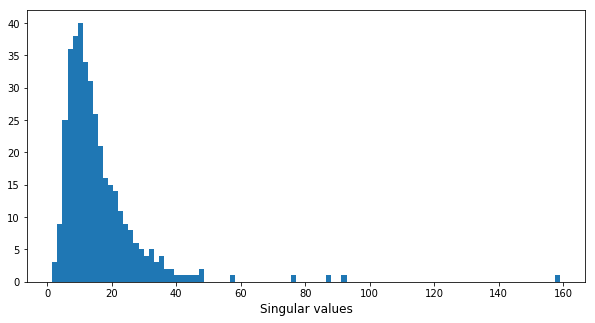

In [18]:
plt.figure(figsize=(10,5))
plt.hist(s, bins=100)
plt.xlabel('Singular values', fontsize=12)
plt.show()

From the plot above, we see that most singular values are between 0 and 30. Then we could try to draw the following plot and see if we could work out the number of topics by seeing the proportion of sum of first k diagonal values of s over the sum of all the diagonal values of s.

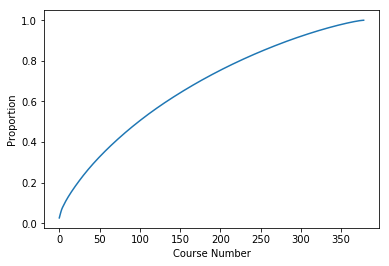

In [19]:
values = []

for i in range(len(courses_name)+1):
    values.append(sum(list(s)[:i])/sum(list(s)))
values.pop(0)
    
plt.plot(list(range(len(courses_name))), values)
plt.xlabel('Course Number')
plt.ylabel('Proportion')
plt.show()

From the firgure above, we see the the proportion grows steadily and it seems hard to find a very appropriate number of topics. But let's try k = 10 first.

For the function models.LsiModel, we use the TF-IDF values as the inputs and we assume that there are 10 different topics for this Coursera dataset. Then we could construct the following LSI model:

In [20]:
lsi = models.LsiModel(corpus = corpus_tfidf, id2word=dictionary, num_topics=40)

We could see each topic by using the print_topic function. From the results we could see some negative values, which is the main reason why the result given by LSA is hard to interprete.

In [21]:
lsi.print_topics(-1)

[(0,
  '0.254*"teach" + 0.151*"nbsp" + 0.136*"program" + 0.121*"learn" + 0.118*"mus" + 0.105*"heal" + 0.101*"comput" + 0.099*"stud" + 0.096*"network" + 0.093*"design"'),
 (1,
  '0.592*"de" + 0.381*"la" + 0.215*"en" + 0.174*"à" + 0.162*"cour" + 0.148*"los" + 0.144*"que" + 0.141*"les" + 0.136*"un" + 0.111*"curso"'),
 (2,
  '0.627*"teach" + 0.200*"portfolio" + 0.185*"assist" + -0.161*"mus" + 0.128*"improv" + 0.122*"profess" + 0.115*"learn" + 0.114*"undertak" + 0.113*"strongly" + -0.112*"network"'),
 (3,
  '0.807*"mus" + 0.170*"sound" + -0.169*"heal" + 0.095*"art" + 0.094*"audio" + 0.090*"digit" + -0.083*"econom" + -0.079*"glob" + 0.073*"composit" + 0.069*"program"'),
 (4,
  '-0.371*"heal" + 0.288*"program" + 0.214*"comput" + -0.212*"mus" + 0.183*"dat" + 0.183*"langu" + 0.180*"algorithm" + -0.167*"glob" + 0.142*"network" + -0.124*"food"'),
 (5,
  '-0.498*"heal" + -0.243*"program" + -0.172*"nutrit" + 0.161*"busy" + 0.149*"network" + 0.146*"gam" + 0.131*"econom" + -0.128*"diseas" + -0.125*"l

With this LSI model, we could project our corpus to a 10-dimensional space.

In [22]:
corpus_lsi = lsi[corpus_tfidf]

Then we could compute the similarity between different documents.

In [23]:
index = similarities.MatrixSimilarity(lsi[corpus])

For instance, if a user has finished Andrew Ng's course Machine learning, he wants to study other courses which also contains machine learning. Hence, firstly we construct the bag-of-words framework for this course.

In [24]:
ml_course = text_stemmed[210]
ml_bow = dictionary.doc2bow(ml_course)

In [25]:
ml_lsi = lsi[ml_bow]
print(ml_lsi)

[(0, 8.5485580922000093), (1, -0.66901400411591572), (2, 0.96939856954657111), (3, 0.14419137883740374), (4, 4.4842786142391384), (5, -0.63871710787005653), (6, 1.8544108702343389), (7, -1.5578539808775924), (8, 0.21876436909257765), (9, -0.83653882629640308), (10, -0.59051008891912238), (11, -2.2101254542907682), (12, -1.1131798763460929), (13, 0.68349555633275483), (14, -1.7199638263129413), (15, -1.2323066680492241), (16, 2.5801510876941269), (17, -0.43949019249001986), (18, -1.7205669086406716), (19, -2.3502772972295025), (20, -3.3982464203883564), (21, -3.5127768293370822), (22, 0.33597584172806921), (23, -2.2875130290533563), (24, 3.0535972663112352), (25, 0.0046456355149368384), (26, 3.9759257135703154), (27, -2.2890324097131587), (28, 1.8169077159331271), (29, -1.3698405721758762), (30, -1.7738199171459679), (31, 4.160351854562081), (32, -3.8451242302972464), (33, -1.3207466153036231), (34, -0.44917017085171418), (35, 0.20336013741910067), (36, -1.3854738279576713), (37, -1.336

In [26]:
sims = index[ml_lsi]

In [27]:
sort_sims = sorted(enumerate(sims), key=lambda item: -item[1])
print(sort_sims[:10])

[(210, 1.0), (174, 0.94567072), (203, 0.83867598), (238, 0.77372283), (208, 0.64551115), (142, 0.59658444), (144, 0.58162582), (262, 0.5783186), (70, 0.57714248), (185, 0.57570082)]


Hence we finally get the courses which are most close to Andrew's course 'machine learning' are:

In [28]:
course_id = [course[0] for course in sort_sims[:10]]
top_10_courses = [courses_name[i] for i in course_id]
print(top_10_courses)

['Machine Learning', 'Machine Learning', 'Neural Networks for Machine Learning', 'Probabilistic Graphical Models', 'Engaging Students through Cooperative Learning', 'Control of Mobile Robots', 'Natural Language Processing', 'The Future of Humankind', 'Artificial Intelligence Planning', 'Introduction to Databases']


The results look quite reasonable. But the LSI model does have the following **issues**:

1. This model is computationally expensive, especially when we are analyzing the large corpus(The speed could be improved by implementing the NMF decomposition).
2. It is hard to select the appropriate $k$.
3. The result is hard to interpret.

4. The LSI model does not take into account **the prior information**.

### 2.3.2 LDA Model

In this section, we choose another model called **Latent Dirichlet allocation(LDA)** to do the recommendation.

For this Coursera corpus, we could also run a LDA model using the following code:

In [29]:
lda = models.LdaModel(corpus_tfidf, id2word = dictionary, num_topics = 10)

Unlike LSA, the topics coming from LDA are easier to interpret.

In [30]:
lda.print_topics(-1)

[(0,
  '0.002*"teach" + 0.001*"crit" + 0.001*"epigenet" + 0.001*"glob" + 0.001*"writ" + 0.001*"erupt" + 0.001*"myst" + 0.001*"rel" + 0.001*"latin" + 0.001*"think"'),
 (1,
  '0.001*"design" + 0.001*"langu" + 0.001*"mus" + 0.001*"stat" + 0.001*"model" + 0.001*"mathem" + 0.001*"nbsp" + 0.001*"diabet" + 0.001*"rock" + 0.001*"analys"'),
 (2,
  '0.002*"de" + 0.002*"teach" + 0.002*"clin" + 0.001*"innov" + 0.001*"los" + 0.001*"plan" + 0.001*"la" + 0.001*"org" + 0.001*"program" + 0.001*"gam"'),
 (3,
  '0.003*"mus" + 0.002*"teach" + 0.002*"network" + 0.002*"’" + 0.001*"cre" + 0.001*"comput" + 0.001*"nbsp" + 0.001*"onlin" + 0.001*"architect" + 0.001*"algorithm"'),
 (4,
  '0.002*"nbsp" + 0.002*"de" + 0.002*"engin" + 0.001*"glob" + 0.001*"mus" + 0.001*"inform" + 0.001*"optim" + 0.001*"technolog" + 0.001*"hist" + 0.001*"econom"'),
 (5,
  '0.003*"heal" + 0.002*"food" + 0.002*"dat" + 0.002*"nbsp" + 0.002*"econom" + 0.002*"mus" + 0.002*"system" + 0.002*"car" + 0.001*"im" + 0.001*"glob"'),
 (6,
  '0.002

As usual, a trained model could be used to transform documents into LDA topic distributions.

In [31]:
corpus_lda = lda[corpus_tfidf]

In [32]:
index = similarities.MatrixSimilarity(lda[corpus])

Then let's try the Andrew's machine learning course again and see the top 10 courses recommended by our LDA model.

In [33]:
ml_lda = lda[ml_bow]
print(ml_lda)

[(3, 0.091668793038032242), (5, 0.74729241311968397), (6, 0.11930352206613851), (8, 0.038305853780477524)]


In [34]:
sims = index[ml_lda]

In [35]:
sort_sims = sorted(enumerate(sims), key=lambda item: -item[1])
print(sort_sims[:10])

[(210, 1.0), (2, 0.98687202), (223, 0.98411947), (182, 0.98392034), (39, 0.98149019), (350, 0.97991532), (35, 0.97909325), (61, 0.97909325), (77, 0.97909325), (114, 0.97909325)]


In [36]:
course_id = [course[0] for course in sort_sims[:10]]
top_10_courses = [courses_name[i] for i in course_id]
print(top_10_courses)

['Machine Learning', 'General Game Playing', 'Introduction to Art: Concepts & Techniques', 'Introduction to Pharmacy', 'Health Policy and the Affordable Care Act', 'Grow to Greatness: Smart Growth for Private Businesses, Part II', 'Introduction to Data Science', 'Corporate Finance', 'Global Sustainable Energy: Past, Present and Future', 'Algorithms, Part II']


From the results, it seems that courses recommended by our LDA model is not reasonable. Courses such as 'Fundamentals of Pharmacology' seems to have little correlation with machine learning.

### 2.3.3 Word embeddings

Word embedding is currently one of the most successful unsupervised learning methods. It is extremely user-friendly and it could work out the semantic correlation between words. For this Coursera case, we could also use the word representations to work out the similarity between different documents.

Firstly, let's use models in gensim to work out the word vectors(here we use the **text_filtered** to train the word representations)

In [157]:
wv_model = models.Word2Vec(text_filtered, size = 200, window = 5, min_count = 0, workers = 4)

In [162]:
wv_model.similarity('computer','bad')

0.98171254159770216

Then we save the model and load it

In [38]:
%time

wv_model.save('word2vec')
wv_model = models.Word2Vec.load('word2vec')

Wall time: 0 ns


Then we could view the word vector of some words using the following code:

In [142]:
wv_model.wv['computer']

array([ 0.24639525,  0.11655792, -0.27122951, -0.19605167,  0.21520194,
       -0.22923346,  0.37800202,  0.01353453, -0.27455196, -0.21519674,
        0.03776409, -0.12592548,  0.09522996, -0.29824027,  0.05373111,
        0.29489404,  0.16451515, -0.23683299,  0.0855662 ,  0.01766715,
        0.17847231, -0.39047569, -0.10451546, -0.21391773, -0.19697911,
       -0.24453199,  0.02158133,  0.17371058, -0.42769858, -0.15482022,
        0.033733  ,  0.09722292,  0.0699039 , -0.1140397 , -0.18423349,
        0.13122234,  0.03839058, -0.02559785, -0.05420973, -0.00815417,
       -0.02106031,  0.13738137, -0.53220558, -0.37813947,  0.18274286,
       -0.03851686,  0.11553536,  0.11505314,  0.05292136,  0.32064611,
       -0.0248908 ,  0.49275985, -0.17821866, -0.00203701, -0.11363039,
       -0.21345028,  0.09823497, -0.07199311,  0.02566207, -0.01285133,
       -0.06261303, -0.19467245,  0.14417915, -0.04727802, -0.17136635,
        0.12225059, -0.02955891,  0.26160771, -0.19932991,  0.07

Until now, we have got the word vector of a word. So how to get the representation of a course? A common idea is that we could use the TF-IDF value of a word as weight. If we use $D_i$ to denote the representation of a document i and let n denote the number of words in this document, $T_{i,j}$ and $W_{i,j}$ represents the TF-IDF value and word vector of a word, then the representation of a document is:

\begin{equation}
D_i = \sum_{j=1}^{n} T_{i,j}W_{i,j}
\end{equation}

Firstly, we calculate the TF-IDF value of these words.

In [129]:
def tfidf_value(corpus, target_word):
    count_tf = 0
    count_idf = 0
    tf = 0
    idf = 0
    tfidf = 0
    for document in corpus:
        count_tf += document.count(target_word)
        if target_word in document:
            count_idf += 1
        else:
            pass
    tf = count_tf/50386 # 50386 means total number of words in text_filtered
    idf = math.log((len(corpus)+1)/count_idf+1)
    tfidf = idf * tf
    return tfidf

dict_with_tfidf = {}

for document in text_filtered:
    for word in document:
        dict_with_tfidf[word] = tfidf_value(text_filtered, word)

Wall time: 0 ns


Based on these tfidf value, we could get the representation of the first course using the following codes:

In [130]:
def course_repre(course):
    new_word_vec = {}
    for word in course:
        new_word_vec[word] = dict_with_tfidf[word]*wv_model.wv[word]
    return new_word_vec

courses_repre = {}
for i in range(len(text_filtered)):
    courses_repre[i] = np.sum(list(course_repre(text_filtered[i]).values()), axis = 0)

In [132]:
list(courses_repre.values())[1]

array([ 0.04427937,  0.0130554 , -0.05602559, -0.03357764,  0.03808948,
       -0.03837284,  0.0523916 ,  0.01495533, -0.05259966, -0.05051561,
        0.01245939, -0.01766909,  0.00670741, -0.03801419,  0.01271602,
        0.05752096,  0.02570274, -0.05964681,  0.00629226,  0.02107507,
        0.04033204, -0.06100152, -0.0110378 , -0.04774882, -0.04237799,
       -0.04861467,  0.00045835,  0.04228117, -0.09911218, -0.03623043,
        0.01560822,  0.00501446,  0.01501018, -0.01702392, -0.03155623,
        0.03642877,  0.01132398, -0.01263214, -0.00709316,  0.00400204,
        0.00846095,  0.02001114, -0.09377978, -0.07756289,  0.04162082,
        0.0001427 ,  0.02772661,  0.02417291,  0.00191568,  0.05920431,
       -0.00757979,  0.08949264, -0.0384629 , -0.00868316, -0.01747917,
       -0.02799903,  0.02166285, -0.01112453,  0.00645698, -0.02078258,
       -0.01413415, -0.0278128 ,  0.02406976,  0.00617541, -0.0136947 ,
        0.01184485, -0.00845916,  0.05052168, -0.03640736,  0.00

However, it seems that word2vec method is not appropriate for this task. If we just use cosine similarity to measure the difference of two vectors, we could get the the following similarity matrix.

In [134]:
a = list(courses_repre.values())[0]
b = list(courses_repre.values())[210]
matrix = np.array([a,b])

cosine_similarity(matrix)

array([[ 1.00000012,  0.99999338],
       [ 0.99999338,  1.00000024]], dtype=float32)

In [163]:
courses_name[0]

'Writing II: Rhetorical Composing'

The first course 'Writing II: Rhetorical Composing' seems to have no relationship with machine learning but from the matrix it tells us that these two courses are very similar.